# GPkit Example: Simple Aircraft Modeling
-----------------------------------

_Based on "Geometric Programming for Aircraft Design Optimization" by Hoburg and Abbeel, and using [GPkit](https://github.com/appliedopt/gpkit) for model representation and solver interfacing._

### Design objective

An airplane with that consumes as little fuel as possible when cruising (while remaining capable of taking off from the ground, with wings that won't break, etc.)

## 1. Set up the modeling environment

Start by importing Numpy and GPkit, and turning on LaTex printing for GPkit variables and equations:

In [289]:
#import pkg_resources
#pkg_resources.require("ipywidgets==4.1.1")
import ipywidgets
print ipywidgets.__version__

import numpy as np
import gpkit
import gpkit.interactive

6.0.0


In [290]:
import IPython
print IPython.__version__


5.4.1


Next declare constants (including take-off and cruising speed, which will be 'swept' over a range of values):

In [291]:
k = gpkit.Variable("k", 1.2, "-", "form factor")
e = gpkit.Variable("e", 0.95, "-", "Oswald efficiency factor")
# V = gpkit.Variable("V", ("sweep", np.linspace(45, 55, 5)), "m/s", "cruising speed")  # sweep and autosweep dont work well together
V = gpkit.Variable("V", 50, "m/s", "cruising speed")
pi = gpkit.Variable("\\pi", np.pi, "-", "half of the circle constant")
mu = gpkit.Variable("\\mu", 1.78e-5, "kg/m/s", "viscosity of air")
rho = gpkit.Variable("\\rho", 1.23, "kg/m^3", "density of air")
tau = gpkit.Variable("\\tau", 0.12, "-", "airfoil thickness to chord ratio")
W_0 = gpkit.Variable("W_0", 4940.0, "N", "aircraft weight excluding wing")
CDA0 = gpkit.Variable("(CDA0)", 0.031, "m^2", "fuselage drag area")
N_ult = gpkit.Variable("N_{ult}", 3.8, "-", "ultimate load factor")
# V_min = gpkit.Variable("V_{min}", ("sweep", np.linspace(20, 25, 5)), "m/s", "takeoff speed")
V_min = gpkit.Variable("V_{min}", 22, "m/s", "takeoff speed")
C_Lmax = gpkit.Variable("C_{L,max}", 1.5, "-", "max CL with flaps down")
S_wetratio = gpkit.Variable("(\\frac{S}{S_{wet}})", 2.05, "-", "wetted area ratio")

Then declare the rest of the variables (there's no need to separate variables and constants like this, I just find it a little more readable):

In [292]:
D = gpkit.Variable("D", "N", "total drag force")
A = gpkit.Variable("A", "-", "aspect ratio")
S = gpkit.Variable("S", "m^2", "total wing area")
W = gpkit.Variable("W", "N", "total aircraft weight")
Re = gpkit.Variable("Re", "-", "Reynold's number")
W_w = gpkit.Variable("W_w", "N", "wing weight")
C_D = gpkit.Variable("C_D", "-", "Drag coefficient of wing")
C_L = gpkit.Variable("C_L", "-", "Lift coefficent of wing")
C_f = gpkit.Variable("C_f", "-", "skin friction coefficient")

LaTex makes it easier to check one's equations (note the use of == to form an equality constraint):

In [293]:
D == 0.5*rho*S*C_D*V**2

gpkit.MonomialEquality(D = 0.5*C_D*S*V**2*\rho)

## 2. Write the system's equations

The drag and wing-weight models consist of several sub-models, so we'll write them here for convenience:

In [294]:
equations = []

C_D_fuse = CDA0/S                                   # Fuselage viscous drag
C_D_wpar = k*C_f*S_wetratio                         # wing parasitic drag
C_D_ind = C_L**2/(pi*A*e)                           # and induced drag
equations += [C_D >= C_D_fuse + C_D_wpar + C_D_ind] # together make a drag model


W_w_strc = (8.71e-5*1/gpkit.units.m)*(N_ult*A**1.5*(W_0*W*S)**0.5)/tau # A model for the wing's structural members
W_w_surf = (45.24*gpkit.units.N/gpkit.units.m**2)*S                    # and the weight of the wing's 'skin'
equations += [W_w >= W_w_surf + W_w_strc]                              # form a model of total wing weight

Then we'll write the rest of the system's equations:

In [295]:
equations += [D >= 0.5*rho*S*C_D*V**2,        # the definition of C_D
              Re <= (rho/mu)*V*(S/A)**0.5,    # the definition of Reynold's number
              C_f >= 0.074/Re**0.2,           # a skin friction model
              W <= 0.5*rho*S*C_L*V**2,        # a cruising lift constraint
              W <= 0.5*rho*S*C_Lmax*V_min**2, # a takeoff lift constraint
              W >= W_0 + W_w]                 # the definition of aircraft weight

In [296]:
equations

[gpkit.PosynomialInequality(C_D >= (CDA0)*S**-1 + (\frac{S}{S_{wet}})*C_f*k + A**-1*C_L**2*\pi**-1*e**-1),
 gpkit.PosynomialInequality(W_w >= 45.2*S + 8.71e-05*A**1.5*N_{ult}*S**0.5*W**0.5*W_0**0.5*\tau**-1),
 gpkit.PosynomialInequality(D >= 0.5*C_D*S*V**2*\rho),
 gpkit.PosynomialInequality(Re <= A**-0.5*S**0.5*V*\mu**-1*\rho),
 gpkit.PosynomialInequality(C_f >= 0.074*Re**-0.2),
 gpkit.PosynomialInequality(W <= 0.5*C_L*S*V**2*\rho),
 gpkit.PosynomialInequality(W <= 0.5*C_{L,max}*S*V_{min}**2*\rho),
 gpkit.PosynomialInequality(W >= W_0 + W_w)]

In [297]:
m = gpkit.Model(D,         # Minimize cruising drag
                equations) # subject to our model

We can check that we've got the right equations by examining the LaTex representation of the system:

In [298]:
m

gpkit.Model(
  # minimize
        D
  # subject to
        C_D >= (CDA0)*S**-1 + (\frac{S}{S_{wet}})*C_f*k + A**-1*C_L**2*\pi**-1*e**-1
        W_w >= 45.2*S + 8.71e-05*A**1.5*N_{ult}*S**0.5*W**0.5*W_0**0.5*\tau**-1
        D >= 0.5*C_D*S*V**2*\rho
        Re <= A**-0.5*S**0.5*V*\mu**-1*\rho
        C_f >= 0.074*Re**-0.2
        W <= 0.5*C_L*S*V**2*\rho
        W <= 0.5*C_{L,max}*S*V_{min}**2*\rho
        W >= W_0 + W_w)

## 3. Solve the system

In [299]:
data = m.solve()
print data.table()

Using solver 'cvxopt'
Solving for 9 variables.
Solving took 0.0801 seconds.

Cost
----
 334.8 [N] 

Free Variables
--------------
  A : 6.45              aspect ratio
C_D : 0.01473           Drag coefficient of wing
C_L : 0.2904            Lift coefficent of wing
C_f : 0.003354          skin friction coefficient
  D : 334.8      [N]    total drag force
 Re : 5.231e+06         Reynold's number
  S : 14.78      [m**2] total wing area
  W : 6601       [N]    total aircraft weight
W_w : 1661       [N]    wing weight

Constants
---------
             (CDA0) : 0.031     [m**2]    fuselage drag area
(\frac{S}{S_{wet}}) : 2.05                wetted area ratio
          C_{L,max} : 1.5                 max CL with flaps down
            N_{ult} : 3.8                 ultimate load factor
                  V : 50        [m/s]     cruising speed
            V_{min} : 22        [m/s]     takeoff speed
                W_0 : 4940      [N]       aircraft weight excluding wing
                \mu : 1.78

Solved after  9 passes, cost logtol +/-0.000337
Autosweeping took 0.277 seconds.
Solved after 33 passes, cost logtol +/-0.00086
Autosweeping took 0.712 seconds.
Solved after 33 passes, cost logtol +/-0.00086
Autosweeping took 0.841 seconds.


(<matplotlib.figure.Figure at 0x7596264d9310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7596264bb0d0>)

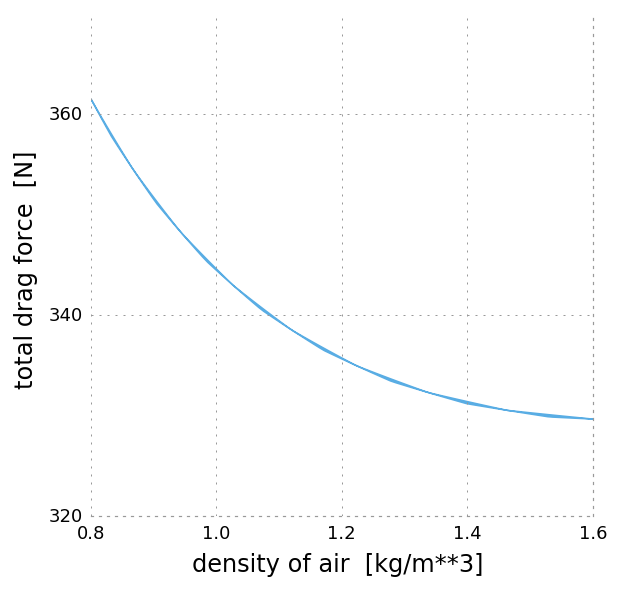

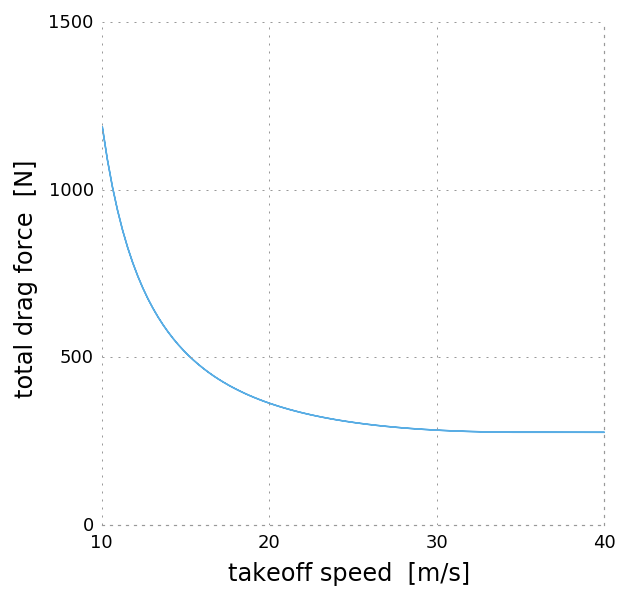

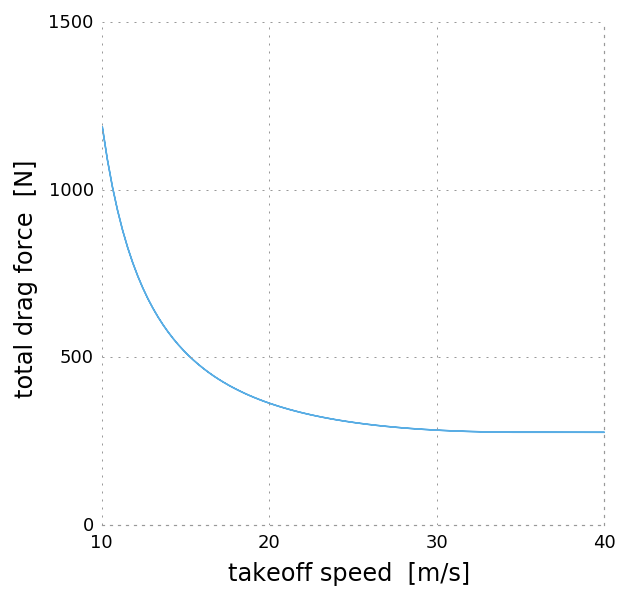

In [300]:
%matplotlib inline        
                            # optional, displays plots in notebook
%config InlineBackend.figure_format = 'retina'
#m.controlpanel([k, mu, rho, A, S, W])  # currently broken due to ipywidgets 6.0.0 update
m.autosweep({rho: (0.8, 1.6)}, tol=0.001).plot(D)  # variable inside plot is y axis, default is cost
m.autosweep({V_min: (10, 40)}, tol=0.001).plot()
m.autosweep({V_min: (10, 40)}, tol=0.001).plot(D)

#sol = m.autosweep({rho: (0.8, 1.6)}, tol=0.001, verbosity=0)
#f, ax = sol.plot(W)
#ax.set_title("blah")
#f.show()
#m.interactive([k, mu, rho, A, S, W])   # currently broken due to ipywidgets 6.0.0 update

## 4. Analyze the system's optimal frontier

GPkit uses matplotlib to visualize the optimal ('Pareto') frontier of a system.

We'll start up the iPython Notebook plotting environment so we can use them:

Plotting any particular design variables is then quite straightforward:

In [301]:
#gpkit.interactive.plotting.plot_frontiers(m, [D, C_D, C_L], 1, 3, (5,5))  # currently broken due to ipywidgets 6.0.0 update

We can see that drag does not increase with cruising speed as drastically as might have been expected.

This is because (under the assumptions of our equations) increasing speed allows one to fly with a smaller and lighter wing.

But don't believe me, take a look at the graphs!

In [302]:
#gpkit.interactive.plotting.plot_frontiers(m, [W_w, S, A], 1, 3, (5,5))  # currently broken due to ipywidgets 6.0.0 update

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
[15 16 17 18 19 20 15 16 17 18 19 20 15 16 17 18 19 20]
[ 95.   96.   96.   97.   98.   99.9  91.   92.   93.   94.   95.5  98.5
  89.   91.   92.   93.   95.   97.5]


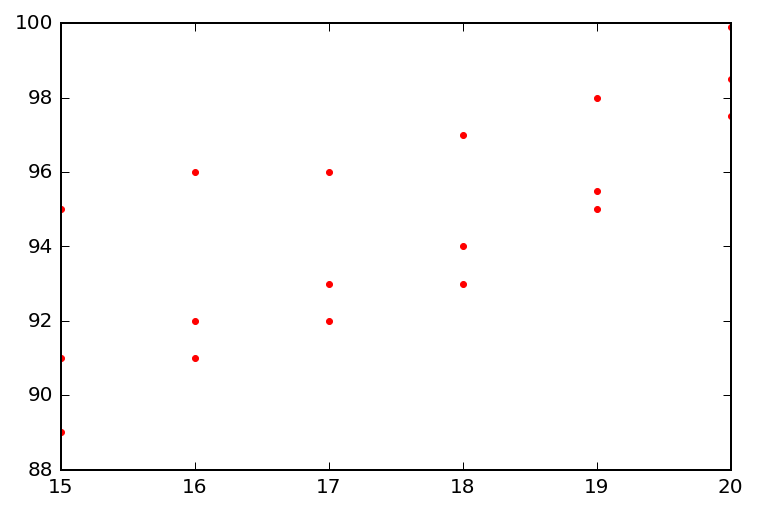

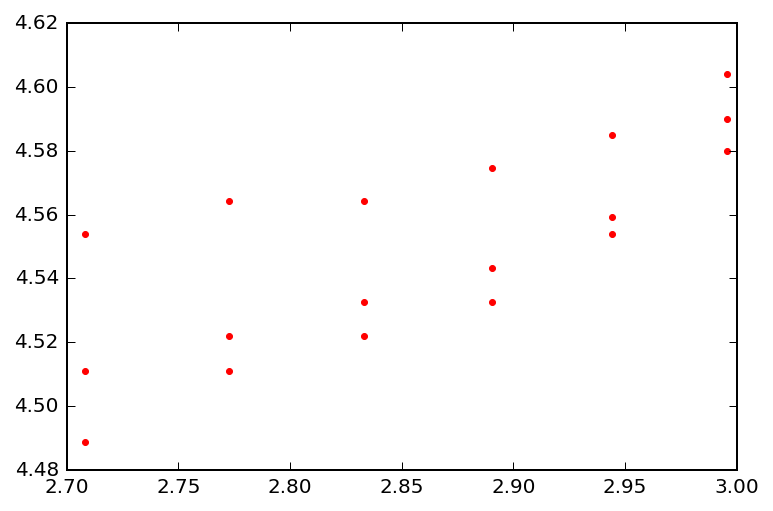

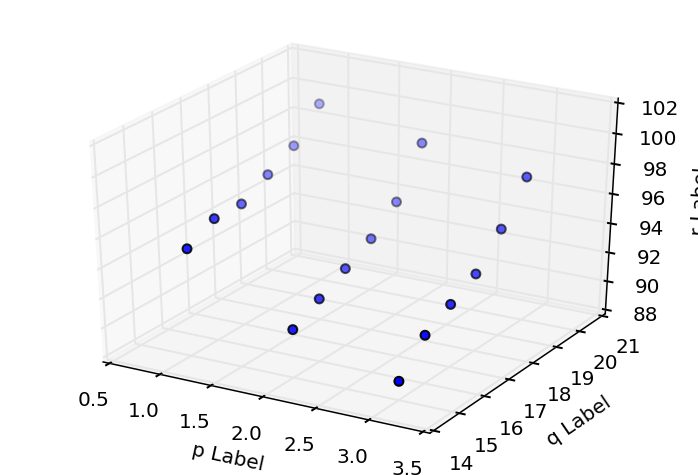

In [303]:
from gpfit.fit import fit
from numpy import logspace, log, log10, random


p = np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])  # "fuel mass"
print p
q = np.array([15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20])  # "power"
print q
r = (-1)*np.array([5, 4, 4, 3, 2, 0.1, 9, 8, 7, 6, 4.5, 1.5, 11, 9, 8, 7, 5, 2.5])+100  # "time between refueling"
# changed some values. nicely convex: [5, 4.6, 4, 3.1, 2, 0.1, 9, 8.3, 7.2, 6, 4.5, 1.5, 10, 9.3, 8.3, 7, 5, 2.5]
print r


import matplotlib.pyplot as plt
plt.plot(q, r, 'r.')
# plt.axis([14, 21, 0, 20])
plt.show()

m = log(q)
n = log(r)
plt.plot(m, n, 'r.')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p, q, r)
ax.set_xlabel('p Label')
ax.set_ylabel('q Label')
ax.set_zlabel('r Label')
plt.show()




In [304]:

u = np.array([p, q])
print u
w = r
print w


x = log(u)
y = log(w)
print x
print y

    
K=2     # what is this?  higher means a closer fit?  kinda. I think just number of fitting curves (terms) allowed
        # can't get above K=3 without getting too large or small of a coefficient. are my data points that bad?

# fixed initial guess for fitting. so it's not different every time
random.seed(33404)
    
    
cMA, errorMA = fit(x, y, K, "MA")    
cSMA, errorSMA = fit(x, y, K, "SMA")
cISMA, errorISMA = fit(x, y, K, "ISMA")     # for my case, off by 0.1 - 0.5



[[ 1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3]
 [15 16 17 18 19 20 15 16 17 18 19 20 15 16 17 18 19 20]]
[ 95.   96.   96.   97.   98.   99.9  91.   92.   93.   94.   95.5  98.5
  89.   91.   92.   93.   95.   97.5]
[[ 0.          0.          0.          0.          0.          0.
   0.69314718  0.69314718  0.69314718  0.69314718  0.69314718  0.69314718
   1.09861229  1.09861229  1.09861229  1.09861229  1.09861229  1.09861229]
 [ 2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227]]
[ 4.55387689  4.56434819  4.56434819  4.57471098  4.58496748  4.60416969
  4.51085951  4.52178858  4.53259949  4.54329478  4.55912625  4.59005655
  4.48863637  4.51085951  4.52178858  4.53259949  4.55387689  4.57985238]
w = 31.53 * (u_1)**-0.0162664 * (u_2)**0.382024
w = 60.045 * (u_1)**-0.0515497 * (u_2)**0.167608
w**0.359144 = 4.06

------------------
_This example was written by Edward Burnell (eburn@mit.edu), who welcomes any comments or suggestions._